In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_pretrained_model/modified/TRAIN/', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_pretrained_model/modified/TEST/', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=False, num_workers=4)

In [3]:
class NewNetwork(nn.Module):
    def __init__(self, num_classes=16):
        super(NewNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, out_channels = 32, kernel_size=6, stride=2, padding=1), #224
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(32, 64, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),
            nn.Conv2d(64, 128, kernel_size=6, stride=2, padding=1), #112
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            #nn.Conv2d(128, 256, kernel_size=6, stride=2, padding=1), #56
            #nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=0.4)
            #nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=1), #28
            #nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=0.5)
            
           
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 1000), #mettre 128 quand il y a 5 couches
            nn.PReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            nn.PReLU(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [4]:
net = NewNetwork()
net.to(device)

NewNetwork(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=1000, bias=True)
    (2): PReLU(num_parameters=1)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): PRe

In [5]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#dynamic learning rate
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

lrs = []
steps = []

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 100)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    if epoch % 10 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with T.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if epoch == 99:
                # Append batch prediction results
                predlist=torch.cat([predlist,predicted.view(-1).cpu()])
                lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)
        
        if epoch % 10 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 0
Train Acc. => 12.338% | Train Loss => 2.73542
Test Acc.  => 16.163% | Test Loss  => 2.66761

Epoch: 10
Train Acc. => 39.918% | Train Loss => 1.70431
Test Acc.  => 39.254% | Test Loss  => 1.67752

Epoch: 20
Train Acc. => 48.745% | Train Loss => 1.46366
Test Acc.  => 47.602% | Test Loss  => 1.48546

Epoch: 30
Train Acc. => 56.728% | Train Loss => 1.22232
Test Acc.  => 50.977% | Test Loss  => 1.30243

Epoch: 40
Train Acc. => 66.634% | Train Loss => 0.95984
Test Acc.  => 60.746% | Test Loss  => 1.05164

Epoch: 50
Train Acc. => 74.539% | Train Loss => 0.69694
Test Acc.  => 70.693% | Test Loss  => 0.79691

Epoch: 60
Train Acc. => 79.953% | Train Loss => 0.54408
Test Acc.  => 73.002% | Test Loss  => 0.68683

Epoch: 70
Train Acc. => 84.092% | Train Loss => 0.42336
Test Acc.  => 77.087% | Test Loss  => 0.63803

Epoch: 80
Train Acc. => 87.015% | Train Loss => 0.33311
Test Acc.  => 82.060% | Test Loss  => 0.53055

Epoch: 90
Train Acc. => 88.368% | Train Loss => 0.29927
Test Acc.  => 82.

## Visualization

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[86  0  1  0  0  0  2  0  0  1  0  0  1  0  0  0]
 [ 0 36  1  6  0  3  1  0  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  1  2  3  0  0  0  1  0  0  0  0  0]
 [ 0 17  1  1  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  1  0 36  2  0  1  0  0  0  0  0  0  0]
 [ 1  0  1  0  4  0 19  0  0  0  3  0  0  0  0  0]
 [ 1  0  0  0  0  4  0 27  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 51  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  1  0  0  0  4  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  2  0 28  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 35  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 19  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 33  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  1]]


<AxesSubplot:>

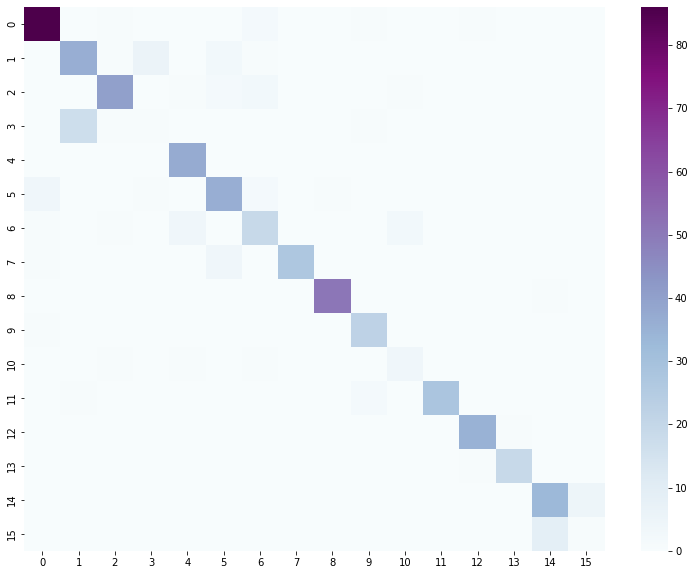

In [9]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=False, ax=ax, cmap="BuPu")

In [10]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[ 94.50549451  76.59574468  85.10638298   5.         100.
  81.81818182  67.85714286  84.375       98.07692308  95.65217391
  57.14285714  90.32258065  97.22222222  95.          86.84210526
  10.        ]


In [11]:
"""
plt.plot(steps, lrs)
plt.xlabel("epoch")
plt.ylabel("learning rate values")
plt.title("learning rate's curve")
plt.show()
"""

'\nplt.plot(steps, lrs)\nplt.xlabel("epoch")\nplt.ylabel("learning rate values")\nplt.title("learning rate\'s curve")\nplt.show()\n'

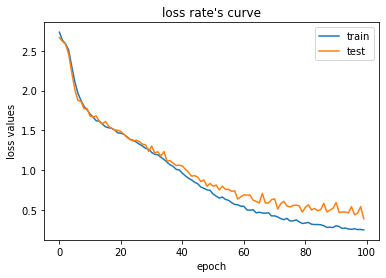

In [12]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

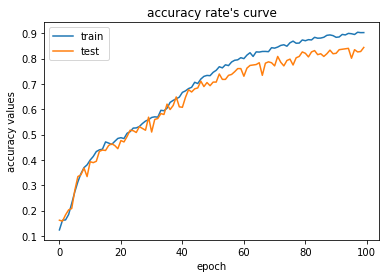

In [13]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

In [14]:
#torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/dict_Linh_network_1st_try")

In [15]:
#torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/Linh_network_entire_model_1st_try")

In [16]:
"""
from torch.utils.data.dataloader import DataLoader


train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

from torchvision.utils import make_grid

def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

"""

'\nfrom torch.utils.data.dataloader import DataLoader\n\n\ntrain_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\nfrom torchvision.utils import make_grid\n\ndef show_batch(dl):\n    #Plot images grid of single batch\n    for images, labels in dl:\n        fig,ax = plt.subplots(figsize = (16,12))\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))\n        break\n        \nshow_batch(train_dl)\n\n'

In [17]:
"""
transform2 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

train_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/TRAIN/', transform=transform2)

train_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

        
show_batch(train_dl2)
"""

"\ntransform2 = transforms.Compose(\n    [transforms.Resize((224, 224)),\n     transforms.ToTensor()])\n\ntrain_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/TRAIN/', transform=transform2)\n\ntrain_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\n        \nshow_batch(train_dl2)\n"